In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import libraries
import time
import random
import json
import os
import sys
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from train import train_model
from utils import *


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/deep learning/Week 03/datasets/The-Nature-Conservancy-Fisheries-Monitoring-master')
sys.path.append('/content/drive/MyDrive/deep learning/Week 03')


In [3]:
def read_annotations(path):
  # Load bounding box annotations from JSON files

    anno_classes = [f.split('_')[0] for f in os.listdir(path)]
    bb_json = {}

    for c in anno_classes:
        j = json.load(open(f'{path}/{c}_labels.json', 'r'))
        for l in j:
            if 'annotations' in l and len(l['annotations']) > 0:
                fname = l['filename'].split('/')[-1]
                bb_json[fname] = sorted(l['annotations'], key=lambda x: x['height'] * x['width'])[-1]

    return bb_json

In [4]:
def bbox_to_r1c1r2c2(bbox):
    """ Convert BB from [h, w, x, y] to [r1, c1, r2, c2] format.
    """

    # extract h, w, x, y and convert to list
    bb = []
    bb.append(bbox['height'])
    bb.append(bbox['width'])
    bb.append(max(bbox['x'], 0))
    bb.append(max(bbox['y'], 0))

    # convert to float
    bb = [float(x) for x in bb]

    # convert to [r1, c1, r2, c2] format
    r1 = bb[3]
    c1 = bb[2]
    r2 = r1 + bb[0]
    c2 = c1 + bb[1]

    return [r1, c1, r2, c2]

In [5]:
def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor.
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)

    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # scale
    hs, ws = img.shape[:2]
    h_scale = h / hs
    w_scale = w / ws

    bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[1], bb[0]
    bw = bb[3] - bb[1]
    bh = bb[2] - bb[0]

    bx *= w * w_scale
    by *= h * h_scale
    bw *= w * w_scale
    bh *= h * h_scale

    # scale image
    img = cv2.resize(img, (w, h))

    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)

    # plot
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()

## Dataset paths

In [34]:
DATA_DIR = '/content/drive/MyDrive/deep learning/Week 03/datasets/The-Nature-Conservancy-Fisheries-Monitoring-master'
train_dir = f'{DATA_DIR}/train'
valid_dir = f'{DATA_DIR}/valid'
anno_dir = f'{DATA_DIR}/BBFish/annos'

sz= 224
batch_size = 32
model_name = 'resnet50'
num_classes = 8

##Read Annotations

In [35]:
bb_json = read_annotations(anno_dir)
print(list(bb_json.keys())[:5])

['img_07911.jpg', 'img_07901.jpg', 'img_07891.jpg', 'img_07854.jpg', 'img_07853.jpg']


In [36]:
anno_files= os.listdir(anno_dir)
anno_files

['yft_labels.json',
 'other_labels.json',
 'shark_labels.json',
 'lag_labels.json',
 'dol_labels.json',
 'alb_labels.json',
 'bet_labels.json']

In [37]:
filename = f'{anno_dir}/{anno_files[0]}'
# print(open(filename, 'r').read())

In [39]:
files = glob.glob(f'{DATA_DIR}/train/*/*.jpg')
files[:5]

['/content/drive/MyDrive/deep learning/Week 03/datasets/The-Nature-Conservancy-Fisheries-Monitoring-master/train/NoF/img_07544.jpg',
 '/content/drive/MyDrive/deep learning/Week 03/datasets/The-Nature-Conservancy-Fisheries-Monitoring-master/train/NoF/img_06601.jpg',
 '/content/drive/MyDrive/deep learning/Week 03/datasets/The-Nature-Conservancy-Fisheries-Monitoring-master/train/NoF/img_06750.jpg',
 '/content/drive/MyDrive/deep learning/Week 03/datasets/The-Nature-Conservancy-Fisheries-Monitoring-master/train/NoF/img_03752.jpg',
 '/content/drive/MyDrive/deep learning/Week 03/datasets/The-Nature-Conservancy-Fisheries-Monitoring-master/train/NoF/img_01020.jpg']

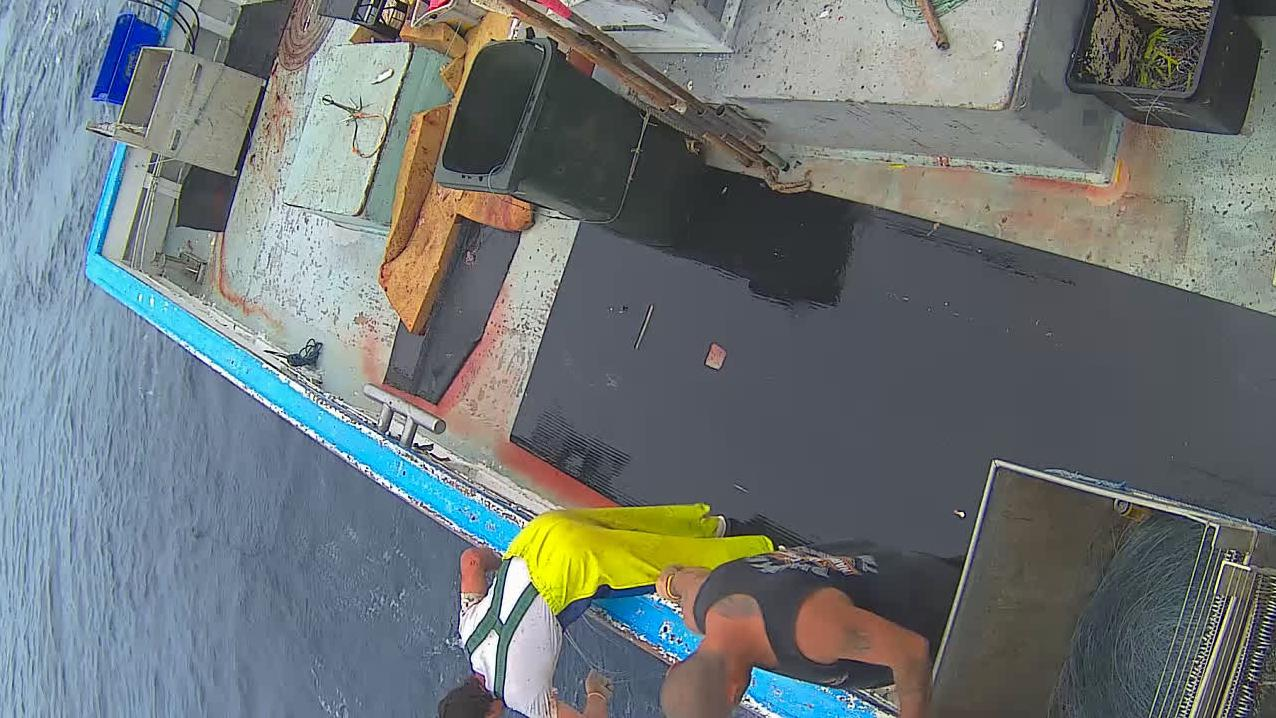

In [40]:
Image.open(files[1])

In [42]:
# Create validation set if it does not exist
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split= 0.2, ext='jpg')

# Dataset class for fish images

In [43]:
class FishDataset(Dataset):
    def __init__(self, ds, bboxes, sz=299):

        self.imgs = ds.imgs
        self.classes = ds.classes
        self.bboxes = bboxes
        self.sz = sz
        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        img, lbl = self.imgs[index]

        # get bounding box
        img_name = os.path.basename(img)
        if img_name in self.bboxes.keys():
            bbox = self.bboxes[img_name]
        else:
            bbox = {'class': 'rect', 'height': 0., 'width': 0., 'x': 0., 'y': 0.}

        # convert [h, w, x, y] to [r1, c1, r2, c2] format
        bbox = bbox_to_r1c1r2c2(bbox)

        # read image and perform transformations
        image = Image.open(img).convert('RGB')
        w, h = image.size

        w_scale = sz / w
        h_scale = sz / h

        # transformations
        image = self.tfms(image)

        # normalize and scale bounding box
        bbox[0] = (bbox[0] / h) * h_scale
        bbox[1] = (bbox[1] / w) * w_scale
        bbox[2] = (bbox[2] / h) * h_scale
        bbox[3] = (bbox[3] / w) * w_scale

        # return image tensor, label tensor and bounding box tensor
        return image, lbl, torch.Tensor(bbox), (w, h)

    def __len__(self):
        return len(self.imgs)

## Training and Validation dataset

In [44]:
train_data = datasets.ImageFolder(train_dir)
train_ds = FishDataset(train_data, bb_json , sz = sz)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle= True)

valid_data = datasets.ImageFolder(valid_dir)
valid_ds = FishDataset(valid_data, bb_json , sz = sz)
valid_dl = DataLoader(valid_ds, batch_size= batch_size, shuffle= False)

# Visulaize data

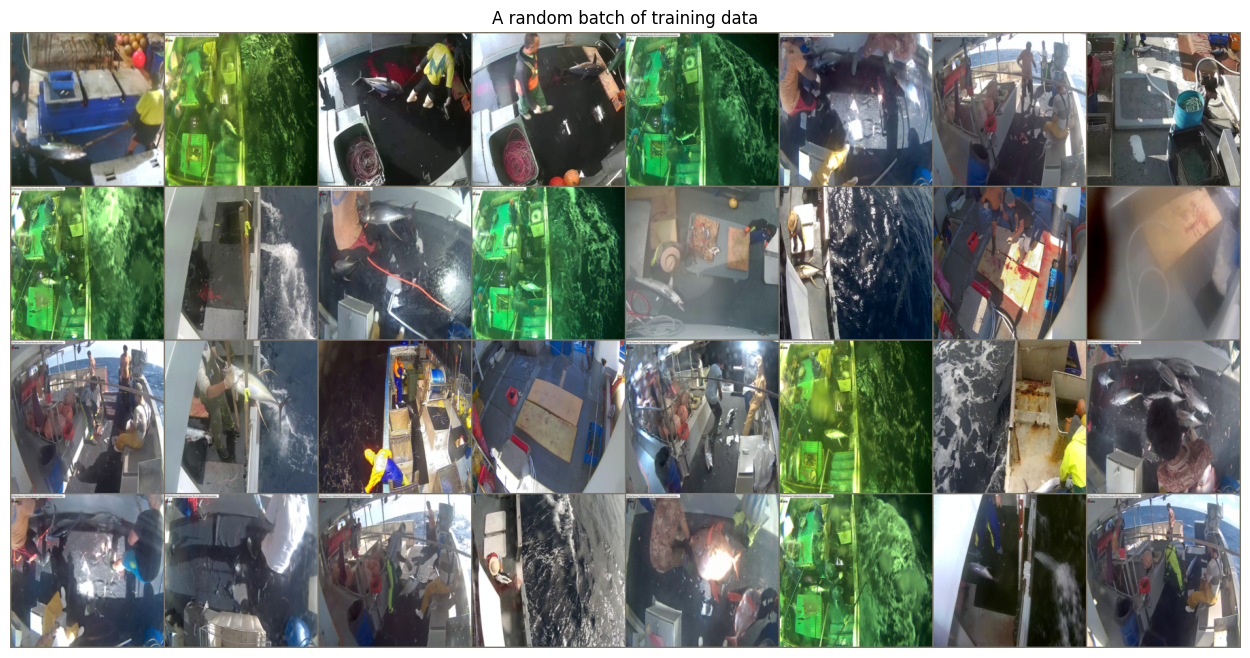

In [46]:
data_iter = iter(train_dl)
imgs, lbls, bboxes, sizes = next(data_iter)
img = torchvision.utils.make_grid(imgs, nrow=8)
plt.figure(figsize=(16, 8))
imshow(img, title='A random batch of training data')

torch.Size([3, 224, 224])
0 : ALB
[0.1510417  0.02544609 0.19090773 0.05166328]


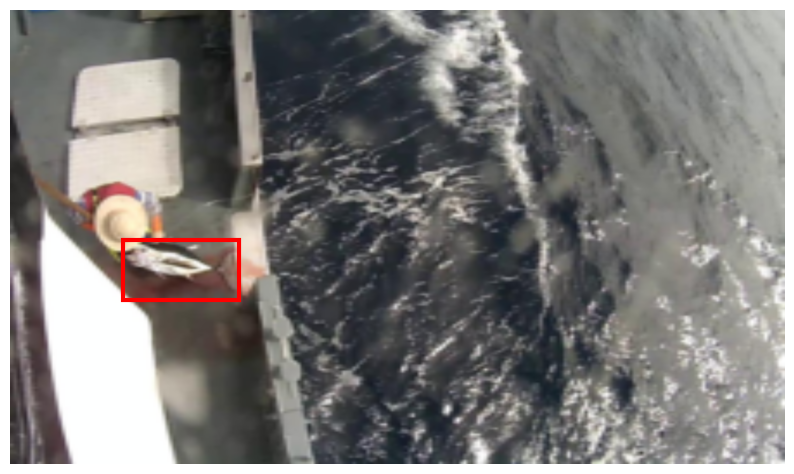

In [47]:
img, lbl, bb, (w, h) = train_ds[10]
print(img.size())
print(lbl ,':', train_ds.classes[lbl])
print(bb.numpy())

plot_bbox(img, bb, w, h)

In [48]:
# Get torchvision model
def get_model(model_name, num_classes, pretrained = True):
    return models.__dict__[model_name](pretrained)

In [49]:
class ClassifierLocalizer(nn.Module):
  # Define model with both classification and localization output
    def __init__(self, model_name, num_classes=8):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes

        # create cnn model
        model = get_model(model_name, num_classes)

        # remove fc layers and add a new fc layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes + 4) # classifier + localizer
        self.model = model

    def forward(self, x):
        x = self.model(x)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # bb corners coordinates
        return scores, torch.sigmoid(coords)     # sigmoid output is in [0, 1]

In [50]:
class LocalizationLoss(nn.Module):
  # Custom loss for joint classification and bounding box regression

    def __init__(self, num_classes=8):
        super(LocalizationLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(reduction='sum')
        self.mse_loss = nn.MSELoss(reduction='sum')

    def forward(self, scores, locs, labels, bboxes):
        # Cross Entropy (for classification)
        loss_cls = self.ce_loss(scores, labels)

        # Sum of Squared errors (for corner points)
        loss_r1 = self.mse_loss(locs[:, 0], bboxes[:, 0]) / 2.0
        loss_c1 = self.mse_loss(locs[:, 1], bboxes[:, 1]) / 2.0
        loss_r2 = self.mse_loss(locs[:, 2], bboxes[:, 2]) / 2.0
        loss_c2 = self.mse_loss(locs[:, 3], bboxes[:, 3]) / 2.0

        return loss_cls, loss_r1 + loss_c1 + loss_r2 + loss_c2


# Initialize model, loss, optimizer, scheduler

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ClassifierLocalizer(model_name)
model = model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
criterion = LocalizationLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

# Train

In [55]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=3)

Epoch 1/3
----------
  train Loss: 30.70136 (21.41811 + 0.92832), Acc: 0.79351
  valid Loss: 8.64107 (7.74435 + 0.08967), Acc: 0.92318

Epoch 2/3
----------
  train Loss: 3.35555 (2.68829 + 0.06673), Acc: 0.98048
  valid Loss: 4.55119 (3.96058 + 0.05906), Acc: 0.96424

Epoch 3/3
----------
  train Loss: 1.16500 (0.70200 + 0.04630), Acc: 0.99570
  valid Loss: 3.91144 (3.39190 + 0.05195), Acc: 0.97219

Training complete in 4m 38s
Best val Acc: 0.9722


## Predict

0 : ALB


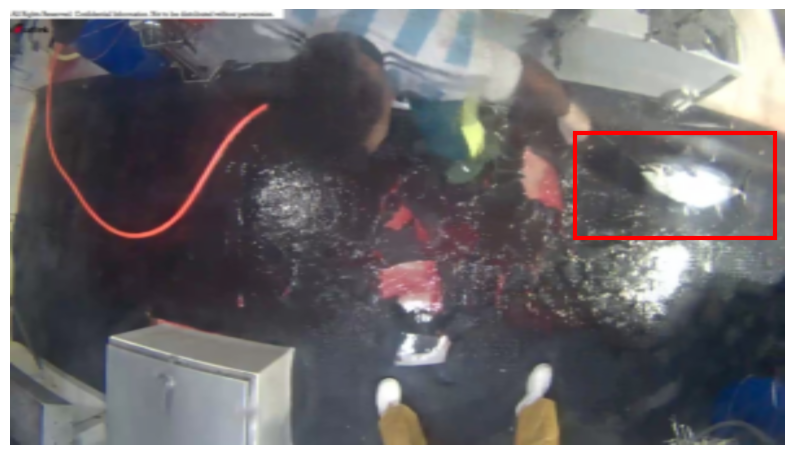

In [33]:
valid_dl = DataLoader(valid_ds, batch_size= 1, shuffle= True)
imgs, lbls, bbs, sizes = next(iter(valid_dl))
scores, locs = model(imgs.to(device))

scores = scores.detach().cpu().numpy()
locs = locs.detach().cpu().numpy()

pred_lbl = np.argmax(scores, axis=1)[0]
pred_bb = locs[0].tolist()

print(pred_lbl, ':', valid_ds.classes[pred_lbl])
w, h = sizes[0].numpy()[0], sizes[1].numpy()[0]

plot_bbox(imgs[0], pred_bb, w, h)